In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

# from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot
from datetime import datetime
import time

In [2]:
games = pd.read_csv('games.csv')
gps = pd.read_csv('gps.csv')
rpe = pd.read_csv('rpe.csv')
wellness = pd.read_csv('wellness.csv')

In [3]:
games.replace('W',1,inplace=True)
games.replace('L',0,inplace=True)

In [4]:
for i, row in rpe.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    rpe.at[i,'Date'] = a1

for i, row in games.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    games.at[i,'Date'] = a1

for i, row in wellness.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    wellness.at[i,'Date'] = a1
    
    #replacing percent strings with float percents
    wellness.at[i,'TrainingReadiness'] = float(row['TrainingReadiness'].strip('%'))

In [5]:
def standardize_col(df, col):
    
    player_grouped = df.groupby('PlayerID')
    
    for p_id in list(range(1,18)):
        mean = player_grouped.get_group(p_id)[col].mean()
        std = player_grouped.get_group(p_id)[col].std()
        for i, row in df.iterrows():
            if row['PlayerID'] == p_id:
                df.at[i, col+'_Z'] = (row[col]-mean)/std
            else:
                pass

wellness_cols = ['Fatigue', 'Soreness', 'Irritability', 'Desire', 'SleepQuality', 'TrainingReadiness']

for col in wellness_cols:
    standardize_col(wellness, col)

standardize_col(rpe,'RPE')

In [6]:
date_grouped = wellness.groupby('Date')
mean_fat = date_grouped['Fatigue_Z'].mean()
mean_sore = date_grouped['Soreness_Z'].mean()
mean_des = date_grouped['Desire_Z'].mean()
mean_irr = date_grouped['Irritability_Z'].mean()
mean_sleepq = date_grouped['SleepQuality_Z'].mean()
mean_sleept = date_grouped['SleepHours'].mean()
mean_readiness = date_grouped['TrainingReadiness_Z'].mean()

for i, row in games.iterrows():
    games.at[i, 'Fat'] = mean_fat[row['Date']]
    games.at[i, 'Sore'] = mean_sore[row['Date']]
    games.at[i, 'Des'] = mean_des[row['Date']]
    games.at[i, 'Irr'] = mean_irr[row['Date']]
    games.at[i, 'SleepQ'] = mean_sleepq[row['Date']]
    games.at[i, 'SleepT'] = mean_sleept[row['Date']]
    games.at[i, 'Readiness'] = mean_readiness[row['Date']]
    
games.head()

,GameID,Date,Tournament,TournamentGame,Team,Opponent,Outcome,TeamPoints,TeamPointsAllowed,Fat,Sore,Des,Irr,SleepQ,SleepT,Readiness
0,1,20171130,Dubai,1,Canada,Spain,1,19,0,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
1,2,20171130,Dubai,2,Canada,Ireland,1,31,0,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
2,3,20171130,Dubai,3,Canada,Fiji,1,31,14,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
3,4,20171201,Dubai,4,Canada,France,1,24,19,-0.352514,-1.085568,1.077209,0.132107,-0.475545,7.171875,0.524882
4,5,20171201,Dubai,5,Canada,Australia,0,7,25,-0.352514,-1.085568,1.077209,0.132107,-0.475545,7.171875,0.524882


In [7]:
well2 = wellness.copy()

In [9]:
import math

In [10]:
well_dates = well2.groupby('Date')
columns = ['Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z',
           'SleepQuality_Z', 'USG']

for i, row in well2.iterrows():
    if row['Date'] < well2['Date'].max():
        date = row['Date']
        next_date = well2[well2['Date'] > date]['Date'].min()
        two_days = well2[well2['Date'] > next_date]['Date'].min()
        three_days = well2[well2['Date'] > two_days]['Date'].min()
        well_rows_next = well_dates.get_group(next_date)
        for i2, row2 in well_rows_next.iterrows():
            pid = row2['PlayerID']
            if row['PlayerID'] == pid:
                for col in columns:
                    well2.at[i, col + '_next'] = row2[col]
        if (not math.isnan(two_days)):
            well_rows_two = well_dates.get_group(two_days)
            for i3, row3 in well_rows_two.iterrows():
                pid = row3['PlayerID']
                if row['PlayerID'] == pid:
                    for col in columns:
                        well2.at[i, col + '_twodays'] = row3[col]
        if (not math.isnan(three_days)):
            well_rows_three = well_dates.get_group(three_days)
            for i4, row4 in well_rows_three.iterrows():
                pid = row4['PlayerID']
                if row['PlayerID'] == pid:
                    for col in columns:
                        well2.at[i, col + '_threedays'] = row4[col]

In [13]:
game2 = games[['GameID', 'Date']].copy()
gps = pd.merge(game2,gps, on=['GameID'])

In [14]:
hits = pd.DataFrame()
# df['GameID'] = gps['GameID']    
hits['PlayerID'] = gps['PlayerID']
hits['Date'] = gps['Date']

# df = df.drop_duplicates(subset=['GameID', 'PlayerID', 'Date'], keep='first')
hits = hits.drop_duplicates(subset=['PlayerID', 'Date'], keep='first')

hits['hits'] = 0

for i, row in hits.iterrows():
    p1 = gps[gps.PlayerID == row.PlayerID]
    p1 = p1[p1.Date == row.Date]
    hit = len(p1[p1.AccelImpulse > 5.8])
    hits.at[i, 'hits'] = hit

In [17]:
x = pd.merge(hits, well2, on=['PlayerID', 'Date'])

In [18]:
x.head()

,PlayerID,Date,hits,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,...,Desire_Z_twodays,Irritability_Z_twodays,SleepQuality_Z_twodays,USG_twodays,Fatigue_Z_threedays,Soreness_Z_threedays,Desire_Z_threedays,Irritability_Z_threedays,SleepQuality_Z_threedays,USG_threedays
0,2,20171130,87,4,4,5,4,21:15:00,06:00:00,8.75,...,NaN,NaN,NaN,NaN,0.207884,-1.060907,-1.234229,-0.186841,-0.100390,NaN
1,3,20171130,50,5,4,6,4,21:30:00,05:30:00,8.00,...,0.757503,0.143069,-2.711368,NaN,-0.578512,-0.279482,-0.629923,0.143069,-2.711368,NaN
2,4,20171130,77,3,6,6,5,01:00:00,07:15:00,6.25,...,-2.863271,-0.940299,-0.707157,NaN,-0.374305,0.507847,0.095762,0.463336,0.774277,NaN
3,6,20171130,48,4,4,4,4,22:00:00,07:15:00,9.25,...,0.126636,0.145116,0.022630,NaN,-1.012796,-0.609797,0.126636,0.145116,1.212985,NaN
4,7,20171130,50,5,4,6,4,21:00:00,06:00:00,9.00,...,-1.365070,-1.334150,-1.150014,NaN,-1.544021,-1.613439,-3.073898,-1.334150,0.187121,NaN


In [20]:
import statsmodels.formula.api as smf

In [31]:
model = smf.ols('Soreness_Z_next ~ hits', data=x)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Soreness_Z_next   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     5.348
Date:                Thu, 11 Apr 2019   Prob (F-statistic):             0.0220
Time:                        22:46:43   Log-Likelihood:                -244.21
No. Observations:                 167   AIC:                             492.4
Df Residuals:                     165   BIC:                             498.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4659      0.171     -2.728      0.007      -0.803      -0.129
hits          -0.0080      0.003     -2.313      0.022      -0.015      -0.001
==============================================================================
Omnibus:                        3.121   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.659
Skew:                           0.279   Prob(JB):                        0.265
Kurtosis:                       3.265   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

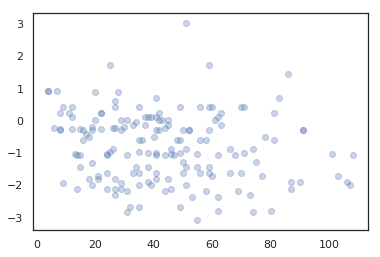

In [33]:
plt.plot(x.hits, x.Soreness_Z_next, 'o',alpha=0.3)

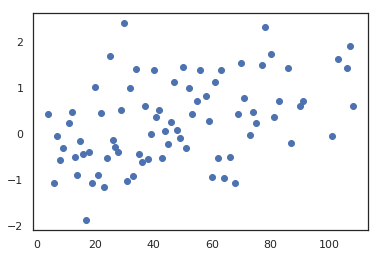

In [34]:
grouped = x.groupby('hits')
series = grouped['Soreness_Z'].mean()
plt.plot(series,'o')

Text(0.5, 1.0, 'Potential Hits vs. Fatigue Rating')

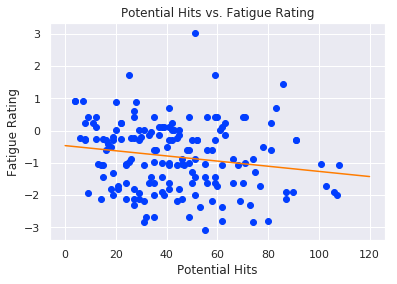

In [36]:
df = pd.DataFrame()
df['hits'] = np.linspace(0,120)
# df['fat2'] = df['Fatigue']**2
# plt.plot(hits_by_fatz, 'o', alpha=0.5)
plt.plot(x.hits, x.Soreness_Z_next,'o')
pred = res.predict(df)
plt.plot(df['hits'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Potential Hits')
plt.ylabel('Fatigue Rating')
plt.title('Potential Hits vs. Fatigue Rating')

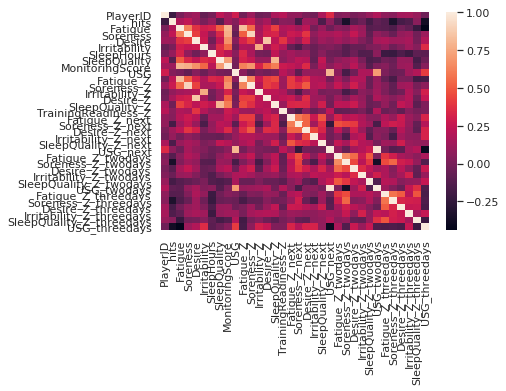

In [26]:
corr = x.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Text(0, 0.5, 'Standardized Fatigue Rating')

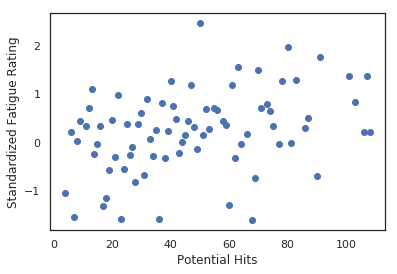

In [28]:
grouped = x.groupby('hits')
hits_by_fatz = grouped['Fatigue_Z'].mean()
plt.plot(hits_by_fatz, 'o')
plt.xlabel('Potential Hits')
plt.ylabel('Standardized Fatigue Rating')

In [39]:
x.columns

Index(['PlayerID', 'Date', 'hits', 'Fatigue', 'Soreness', 'Desire',
       'Irritability', 'BedTime', 'WakeTime', 'SleepHours', 'SleepQuality',
       'MonitoringScore', 'Pain', 'Illness', 'Menstruation', 'Nutrition',
       'NutritionAdjustment', 'USGMeasurement', 'USG', 'TrainingReadiness',
       'Fatigue_Z', 'Soreness_Z', 'Irritability_Z', 'Desire_Z',
       'SleepQuality_Z', 'TrainingReadiness_Z', 'Fatigue_Z_next',
       'Soreness_Z_next', 'Desire_Z_next', 'Irritability_Z_next',
       'SleepQuality_Z_next', 'USG_next', 'Fatigue_Z_twodays',
       'Soreness_Z_twodays', 'Desire_Z_twodays', 'Irritability_Z_twodays',
       'SleepQuality_Z_twodays', 'USG_twodays', 'Fatigue_Z_threedays',
       'Soreness_Z_threedays', 'Desire_Z_threedays',
       'Irritability_Z_threedays', 'SleepQuality_Z_threedays',
       'USG_threedays'],
      dtype='object')

In [42]:
columns = ['Fatigue_Z', 'Soreness_Z', 'Irritability_Z', 'Desire_Z',
       'SleepQuality_Z', 'TrainingReadiness_Z', 'Fatigue_Z_next',
       'Soreness_Z_next', 'Desire_Z_next', 'Irritability_Z_next',
       'SleepQuality_Z_next', 'USG_next', 'Fatigue_Z_twodays',
       'Soreness_Z_twodays', 'Desire_Z_twodays', 'Irritability_Z_twodays',
       'SleepQuality_Z_twodays', 'USG_twodays', 'Fatigue_Z_threedays',
       'Soreness_Z_threedays', 'Desire_Z_threedays',
       'Irritability_Z_threedays', 'SleepQuality_Z_threedays',
       'USG_threedays']

In [43]:
model = smf.ols('Fatigue_Z_next ~ hits', data=x)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fatigue_Z_next   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4163
Date:                Thu, 11 Apr 2019   Prob (F-statistic):              0.520
Time:                        22:51:58   Log-Likelihood:                -266.64
No. Observations:                 167   AIC:                             537.3
Df Residuals:                     165   BIC:                             543.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6092      0.195     -3.119      0.002      -0.995      -0.223
hits           0.0025      0.004      0.645      0.520      -0.005       0.010
==============================================================================
Omnibus:                        2.055   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.358   Jarque-Bera (JB):                1.969
Skew:                          -0.264   Prob(JB):                        0.374
Kurtosis:                       2.942   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
for col in columns:
    model = smf.ols(col + ' ~ hits', data=x)
    res = model.fit()
    print(col)
    print("PVal: ", res.pvalues)
    print("Rsquared: ", res.rsquared)

Fatigue_Z
PVal:  Intercept    0.071620
hits         0.000956
dtype: float64
Rsquared:  0.054016286496747834
Soreness_Z
PVal:  Intercept    0.002402
hits         0.000061
dtype: float64
Rsquared:  0.07847158765587348
Irritability_Z
PVal:  Intercept    0.502677
hits         0.233126
dtype: float64
Rsquared:  0.007208888585039985
Desire_Z
PVal:  Intercept    0.000426
hits         0.022540
dtype: float64
Rsquared:  0.02613379065083421
SleepQuality_Z
PVal:  Intercept    0.127361
hits         0.734562
dtype: float64
Rsquared:  0.0005848848087948166
TrainingReadiness_Z
PVal:  Intercept    0.019528
hits         0.415617
dtype: float64
Rsquared:  0.0033666988221909833
Fatigue_Z_next
PVal:  Intercept    0.002145
hits         0.519700
dtype: float64
Rsquared:  0.0025164974344664692
Soreness_Z_next
PVal:  Intercept    0.007055
hits         0.021977
dtype: float64
Rsquared:  0.03139633032542
Desire_Z_next
PVal:  Intercept    0.816242
hits         0.102702
dtype: float64
Rsquared:  0.016058425190611

In [64]:
model = smf.ols('Soreness_Z_next ~ hits', data=x)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Soreness_Z_next   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     5.348
Date:                Thu, 11 Apr 2019   Prob (F-statistic):             0.0220
Time:                        23:14:10   Log-Likelihood:                -244.21
No. Observations:                 167   AIC:                             492.4
Df Residuals:                     165   BIC:                             498.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4659      0.171     -2.728      0.007      -0.803      -0.129
hits          -0.0080      0.003     -2.313      0.022      -0.015      -0.001
==============================================================================
Omnibus:                        3.121   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.659
Skew:                           0.279   Prob(JB):                        0.265
Kurtosis:                       3.265   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Standardized Soreness Rating')

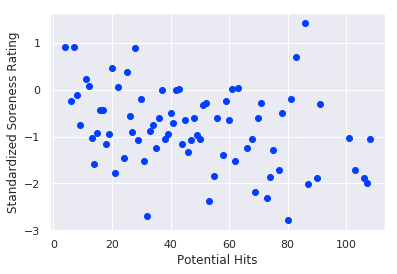

In [65]:
grouped = x.groupby('hits')
hits_by_fatz = grouped['Soreness_Z_next'].mean()
plt.plot(hits_by_fatz, 'o')
plt.xlabel('Potential Hits')
plt.ylabel('Standardized Soreness Rating')

Text(0.5, 1.0, 'Potential Hits vs. Soreness Rating One Day Later')

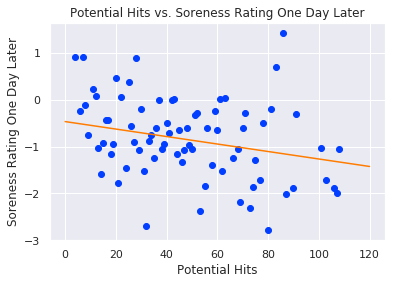

In [66]:
df = pd.DataFrame()
df['hits'] = np.linspace(0,120)
# plt.plot(x.hits, x.Soreness_Z_next,'o')
plt.plot(hits_by_fatz, 'o')
pred = res.predict(df)
plt.plot(df['hits'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Potential Hits')
plt.ylabel('Soreness Rating One Day Later')
plt.title('Potential Hits vs. Soreness Rating One Day Later')

In [46]:
model = smf.ols('Soreness_Z_twodays ~ hits', data=x)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Soreness_Z_twodays   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     18.10
Date:                Thu, 11 Apr 2019   Prob (F-statistic):           3.84e-05
Time:                        22:54:43   Log-Likelihood:                -204.84
No. Observations:                 141   AIC:                             413.7
Df Residuals:                     139   BIC:                             419.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1214      0.192     -0.633      0.528      -0.500       0.258
hits          -0.0170      0.004     -4.254      0.000      -0.025      -0.009
==============================================================================
Omnibus:                       16.987   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.708
Skew:                           0.665   Prob(JB):                     7.11e-06
Kurtosis:                       4.506   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

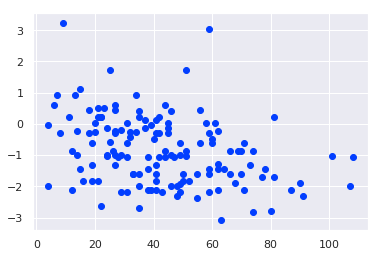

In [47]:
plt.plot(x.hits, x.Soreness_Z_twodays, 'o')

Text(0, 0.5, 'Standardized Soreness Rating')

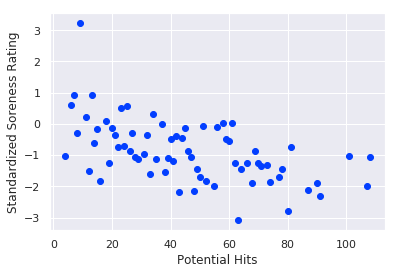

In [49]:
grouped = x.groupby('hits')
hits_by_fatz = grouped['Soreness_Z_twodays'].mean()
plt.plot(hits_by_fatz, 'o')
plt.xlabel('Potential Hits')
plt.ylabel('Standardized Soreness Rating')

Text(0.5, 1.0, 'Potential Hits vs. Soreness Rating Two Days Later')

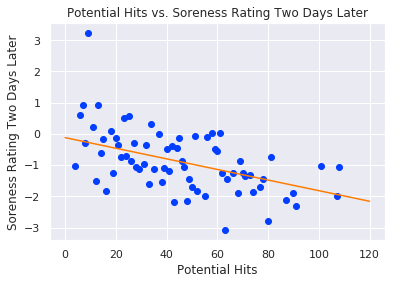

In [54]:
df = pd.DataFrame()
df['hits'] = np.linspace(0,120)
# plt.plot(x.hits, x.Soreness_Z_next,'o')
plt.plot(hits_by_fatz, 'o')
pred = res.predict(df)
plt.plot(df['hits'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Potential Hits')
plt.ylabel('Soreness Rating Two Days Later')
plt.title('Potential Hits vs. Soreness Rating Two Days Later')

In [60]:
model = smf.ols('Soreness_Z_threedays ~ hits', data=x)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Soreness_Z_threedays   R-squared:                       0.104
Model:                              OLS   Adj. R-squared:                  0.098
Method:                   Least Squares   F-statistic:                     16.61
Date:                  Thu, 11 Apr 2019   Prob (F-statistic):           7.59e-05
Time:                          23:12:51   Log-Likelihood:                -204.20
No. Observations:                   145   AIC:                             412.4
Df Residuals:                       143   BIC:                             418.4
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1298      0.173      0.752      0.453      -0.211       0.471
hits          -0.0142      0.003     -4.075      0.000      -0.021      -0.007
==============================================================================
Omnibus:                        9.257   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               10.802
Skew:                           0.437   Prob(JB):                      0.00451
Kurtosis:                       4.012   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Standardized Soreness Rating')

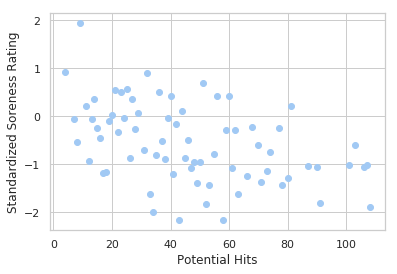

In [61]:
grouped = x.groupby('hits')
hits_by_fatz = grouped['Soreness_Z_threedays'].mean()
plt.plot(hits_by_fatz, 'o')
plt.xlabel('Potential Hits')
plt.ylabel('Standardized Soreness Rating')

Text(0.5, 1.0, 'Potential Hits vs. Soreness Rating Three Days Later')

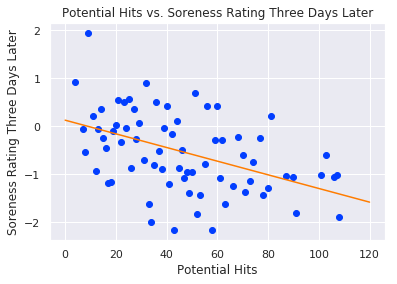

In [63]:
df = pd.DataFrame()
df['hits'] = np.linspace(0,120)
# plt.plot(x.hits, x.Soreness_Z_next,'o')
plt.plot(hits_by_fatz, 'o')
pred = res.predict(df)
plt.plot(df['hits'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Potential Hits')
plt.ylabel('Soreness Rating Three Days Later')
plt.title('Potential Hits vs. Soreness Rating Three Days Later')

Text(0.5, 1.0, 'Does Menstruation affect how many potential hits a player is involved in?')

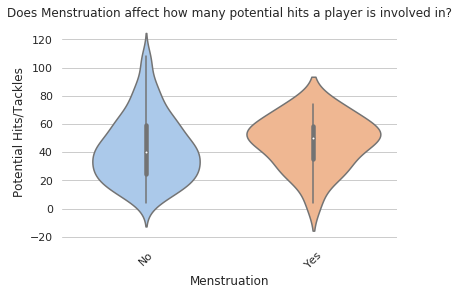

In [59]:
data = x.dropna(subset=['Menstruation', 'hits'])
sns.violinplot(x='Menstruation', y='hits', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('Menstruation')
plt.ylabel('Potential Hits/Tackles');
plt.title('Does Menstruation affect how many potential hits a player is involved in?')